Github Link: https://github.com/SunlightWings/BP-Eye-Foundation-Workshop/blob/main/Pipeline%20Building/README.md

## Objective:
- Learn the steps in pipeline building for an image classification task.

## Background:

Image classification is the process of labeling the objects in an image from a predefined set of categories. Essentially, our task is to analyze an input image and return a label that categorizes the image. The label is always from a predefined set of possible categories.

<center>

<img src="https://drive.google.com/uc?export=view&id=1yPb6s9-MF1-ZOwEcb6Q77c4qTiKNnFGd" alt="Shows image classification problem" height="400" width="800">

Fig: Image Classification task

</center>

The above picture shows a simple image classification task where there are 2 labels. Depending on the problem, there might be more than 2 labels. In such case, the ideal model will be able to differentiate each of the input images and assign the paricular label to it.

## To DO:
- Follow along the steps to train and evaluate the model
- Steps:
  1. Dataset preparation
  2. EDA (Exploratory data analysis)
  3. Model building
  4. Model training
  5. Model evaluation

## About the Dataset:

The eardrum dataset consists of 282 otoscope images collected at Van Akdamar Hospital in Turkey between 2018 and 2019.

* Image Size: 500x500 pixels
* Number of classes: 7 ( 1 normal, 6 abnormal)
  - Normal class = 154 samples
  - Abnormal class = 128 samples
    - AOM = 69
      - Acute Otitis Media (AOM) shows acute inflammation of middle ear, seen mostly in children younger than 5 years.
    - Earwax = 21
      - Though not a disease, it can contribute to infection, earache and ringing noises.
    - Miringoskleroz = 4
      - Calcification of the eardrum, appearing at ehite sclerotic plaques on eardrum.
    - Tympanostomy tubes = 2
      - Small, hollow cylinders inserted into the eardrum. It's also categorized in Abnormal because it is used or patients who have middle ear infections.
    - CSOM = 14
       - A condition that causes persistent drainage from the middle ear (for weeks) due to perforated eardrum.
    - Otitis Externa = 18.
      - Redness or swelling of the ear canal.

## Step 1: Dataset Download

Import necessary libraries.

In [ ]:
import os
import zipfile
import requests
from pathlib import Path

An user-defined function to download the dataset directly from the given url is defined below.

In [ ]:
# Function to download the dataset
def download_and_extract(url, output_path):
    """Download and extract a zip file from a URL."""
    filename = url.split("/")[-1]
    response = requests.get(url, stream=True)
    if response.status_code == 200:                                 # Server successfully answered the http request
        print("Downloading dataset...")
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print("Download complete.")

        # Extracting the zip file
        print("Extracting files...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(output_path)
        print(f"Dataset extracted to {output_path}.")

        # Remove the downloaded zip file
        os.remove(filename)
    else:
        print(f"Failed to download dataset: {response.status_code}")

The 2 arguments to the above function are `output_dir` and `dataset_url`.
So lets define those to call the function.

In [ ]:
output_dir = "./eardrum_data"
Path(output_dir).mkdir(parents=True, exist_ok=True)  # Create output directory if not exists

* **Task 1: Run the following two cells:**

  - Choose an appropriate URL : `https://figshare.com/ndownloader/files/26200970`
  - Call the above function to download the dataset

---




In [ ]:
## TO DO
dataset_url = "_____"   ## fill appropriate URL here

In [ ]:
# Download and extract the dataset

## TO DO
download_and_extract(dataset_url, output_dir)                    ## call the function with 2 arguments

Download complete.
Extracting files...
Dataset extracted to ./eardrum_data.


In [ ]:
print("Files/Directory inside the output_dir:")
print(os.listdir(output_dir))

Files/Directory inside the output_dir:
['eardrum']


## Step 2: Exploratory Data Analysis (EDA)

The following libraries are further needed for visualization.

In [ ]:
pip install pillow

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

A function to display images from each of the 7 categories/classes is defined below

In [ ]:
# Function to display the first N images from each class
def display_images(categories, samples):
    plt.figure(figsize=(16, 28))

    for i, (class_name, path) in enumerate(categories.items()):    # dictionary parsing
        # Get all image files in the directory
        image_files = sorted([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

        # Select the first few images
        selected_images = image_files[:samples]

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(path, img_name)

            # Load and display the image
            # plt.subplot(len(categories), samples, i * samples + j + 1)
            plt.subplot(len(categories), samples, i * samples + j + 1)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{class_name}", fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
data_dir = "eardrum_data/eardrum"    # parent directory

* **Task2: There are 7 classes, one class is in the normal category and 6 classes are in the abnormal category.  Carefully check the directory hierarchy and fill the following Python Dictionary to provide the mapping between category names and their corresponding directory paths.**

  Example:
    - Images in Normal class are in Normal directory
    - Images in AOM class are in the Abnormal/AOM directory
    - Images in CSOM class are in the Abnormal/CSOM directory

In [ ]:
## Fill the names inside the double comma ""
## Don't forget to double check the spelling


## TO DO

categories = {
    "Normal": os.path.join(data_dir, "___"),
    "AOM": os.path.join(data_dir, "Abnormal", "____"),
    "Earwax": os.path.join(data_dir, "Abnormal", "____"),
    "Myringosclerosis": os.path.join(data_dir, "Abnormal", "_____"),
    "Tympanostomy": os.path.join(data_dir, "Abnormal", "______"),
    "CSOM": os.path.join(data_dir, "Abnormal", "_____"),
    "Otitis Externa": os.path.join(data_dir, "Abnormal", "______"),
}

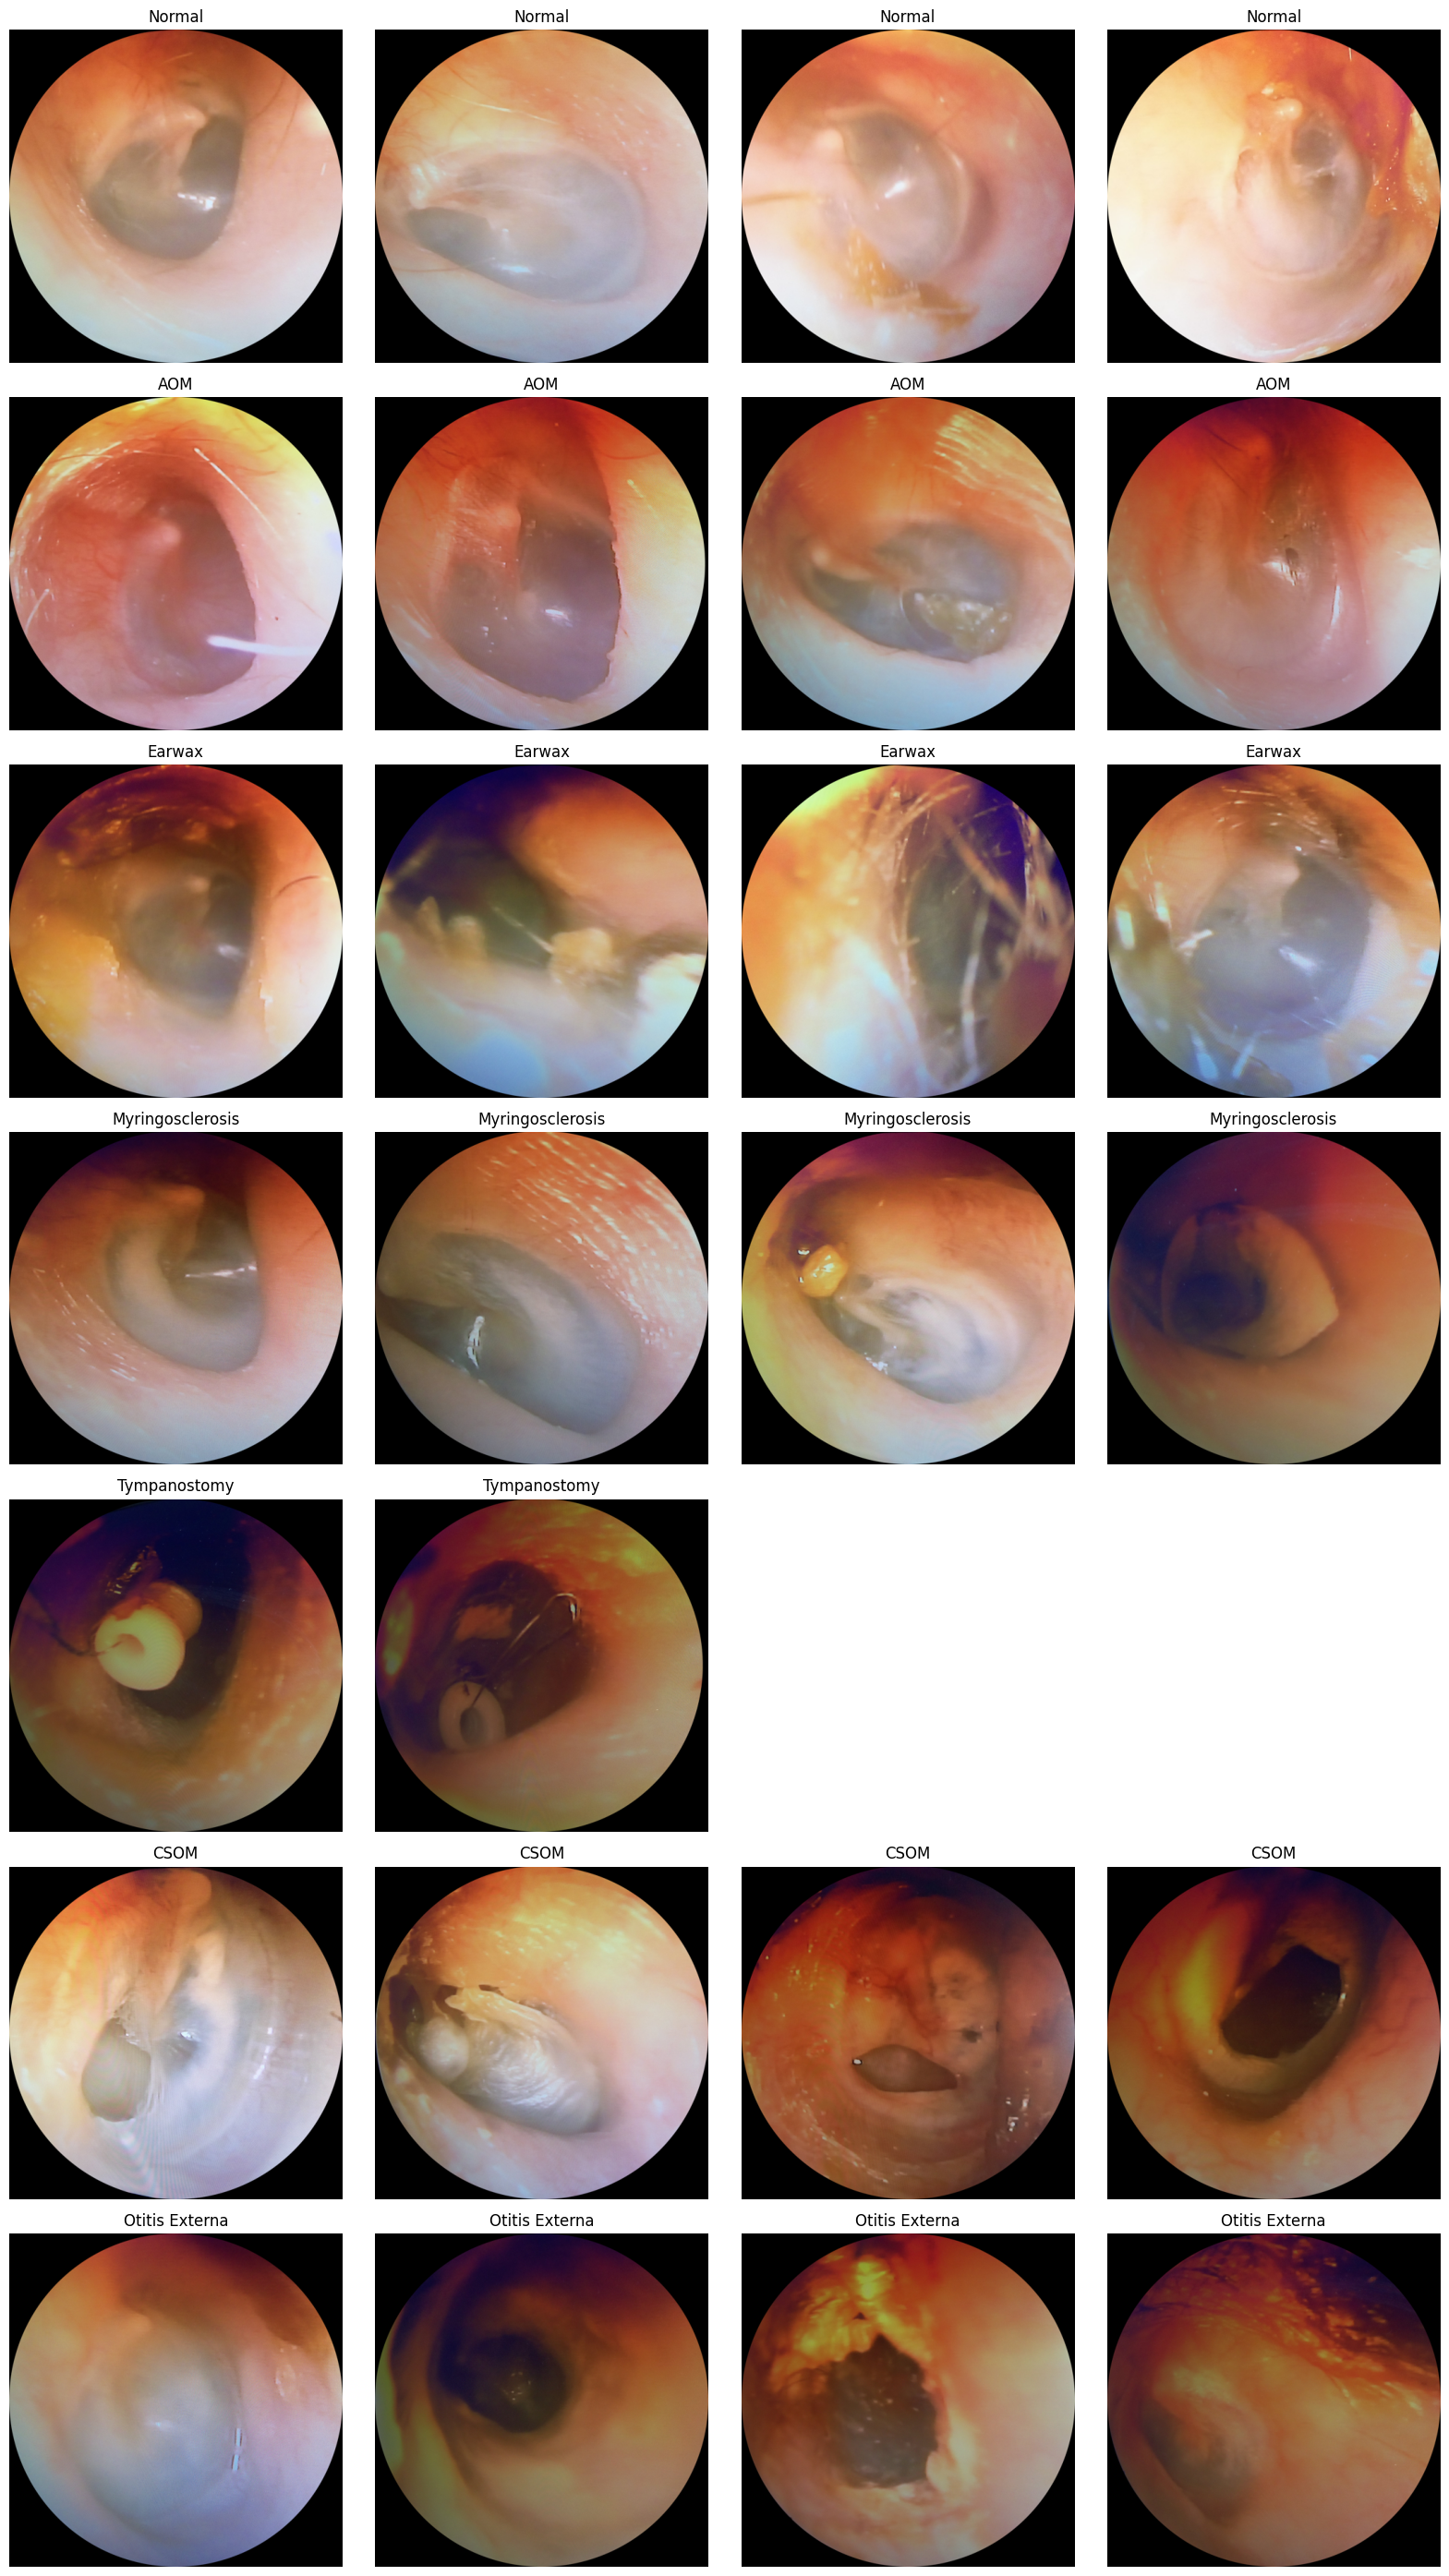

In [ ]:
display_images(categories, samples=4)

## Step 3: Dataset Preprocessing

Lets prepare our data before feeding them to the model.
We will split the data into training set, validation set and test set. We will also create dataloaders.

### 3.a. Dataset Class definition and instantiation
This part has been done for you. Just run these cells.

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Class Definition:

In [ ]:
class EardrumDataset(Dataset):
    def __init__(self, categories, transform=None):
        """
        Args:
            categories (dict): A dictionary with class names as keys and their folder paths as values.
            transform (callable, optional): Optional transforms to apply to the images.
        """
        self.data = []  # List to store (image_path, class_index) pairs
        self.transform = transform
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(categories.keys())}

        # Collect all image paths and their corresponding class indices
        for class_name, folder_path in categories.items():
            class_index = self.class_to_idx[class_name]
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                if os.path.isfile(img_path):
                    self.data.append((img_path, class_index))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure the image is in RGB format

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

Instantiation:

In [ ]:
data_dir = "eardrum_data/eardrum"

categories = {
    "Normal": os.path.join(data_dir, "Normal"),
    "AOM": os.path.join(data_dir, "Abnormal", "AOM"),
    "Earwax": os.path.join(data_dir, "Abnormal", "Earwax"),
    "Myringosclerosis": os.path.join(data_dir, "Abnormal", "Miringoskleroz"),
    "Tympanostomy": os.path.join(data_dir, "Abnormal", "TympanostomyTubes"),
    "CSOM": os.path.join(data_dir, "Abnormal", "CSOM"),
    "Otitis Externa": os.path.join(data_dir, "Abnormal", "OtitisEksterna"),
}

dataset = EardrumDataset(categories, transform=transform)

In [ ]:
print(len(dataset))

282


### 3.b. Train-Validation-Test Split:

In [ ]:
from torch.utils.data import DataLoader, random_split

In [ ]:
total_size = len(dataset)

* **Task3: Split the dataset so as to use 70% images for training, 20% for validation and 10% for testing.**

Hint: `torch.utils.data.random_split(dataset, lengths, generator=torch._C.Generator object)`

In [ ]:
## Fill the percentage ratio here.

## TO DO

train_ratio = 0.7  # 70% for training
val_ratio = ____    # 20% for validation
test_ratio = ____   # 10% for testing

# Calculate split sizes
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

In [ ]:
# Use random_split to create train, validation, and test sets
## TO DO

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

* **Task4: Check the length of the train_set, val_set and test_set to see if the data is split accordingly**

In [ ]:
## Print the length here
## TO DO

print(len(train_set)) # fill here
____________________ # fill here
____________________ # fill here

197
56
29


### 3.c. Dataloader:

Dataloader is used to load the dataset in batch during training/validation instead of loading them one-by-one.

* **Task5: batch_size of 16 has been specified here. And the code for train_loader has been given for you. Complete the remaining code for val_loader and test_loader**

  - Specify the dataset (train_set, val_set or test_set)
  - Also change the batch size to 8


In [ ]:
## TO DO

batch_size = 16   # Change the batch size here

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

## TO DO
## Complete the following 2 lines

val_loader = DataLoader(_____, batch_size=_____, shuffle=False)  # fill here
test_loader = DataLoader(test_set, batch_size=_______, shuffle=False) # fill here

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

25
7
4


In [ ]:
for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Labels in first batch:{labels}")
    break

Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8])
Labels in first batch:tensor([0, 5, 1, 0, 0, 5, 5, 2])


* **Task6: Discuss: What do these labels mean?**
  
  For example, Which class does the label '3' imply?
  
  Hint: Take a look at the instantiation of the Dataset Class.

## Step 4: Model Building:

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision

We need to use metrics for evaluating our dataset. `torchmetrics` is a collection of different metrics and is very easy to use.

In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 22.7 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

Lets create a model for the classification purpose. Note that we have 7 target classes.

In [ ]:
import torchvision
kwargs={}
resnet_model = torchvision.models.resnet50(weights=None, num_classes=7, progress=True, **kwargs)

In [ ]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Step 5: Model Training:

In [ ]:
import torch.optim as optim
from tqdm import tqdm

In [ ]:
from google.colab import drive

# Try unmounting first (in case it was already mounted)
try:
  drive.flush_and_unmount()
  print('Drive unmounted')
except ValueError:
  pass  # Ignore errors if it wasn't mounted

# Clear the directory (be careful, this will delete all files in it)
!rm -rf /content/drive

# Now try mounting again
drive.mount('/content/drive')

Drive unmounted
Mounted at /content/drive


In [ ]:
import os

def train_model(model, train_loader, val_loader, num_epochs, device, save_path):
    # Mount Google Drive (if necessary)
    from google.colab import drive
    drive.mount('/content/drive')

    # Criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    # Initialize logs
    logs = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": []
    }
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_accuracy = correct / total * 100
        logs["train_loss"].append(train_loss)
        logs["train_accuracy"].append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_accuracy = val_correct / val_total * 100
        logs["val_loss"].append(val_loss)
        logs["val_accuracy"].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), os.path.join(save_path, "best_model.pth"))
            print(f"Best model saved with Validation Accuracy: {val_accuracy:.2f}%")

        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), os.path.join(save_path, f"model_epoch_{epoch+1}.pth"))
            print(f"Model saved at epoch {epoch+1}")

    # Save logs for plotting
    torch.save(logs, os.path.join(save_path, "training_logs.pth"))
    print("Training completed and logs saved.")


In [ ]:
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


* **Task7: Specify the path here**

  i.e. Path to save the model and the log

In [ ]:
## TO DO

save_path = '/content/drive/MyDrive/naamii/workshop'  ## Specify here

In [ ]:
train_model(resnet_model, train_loader, val_loader, num_epochs, device, save_path)

Plotting the training details:

In [ ]:
import matplotlib.pyplot as plt

def plot_training_logs(logs_path):
    # Load logs
    logs = torch.load(logs_path)

    train_loss = logs["train_loss"]
    val_loss = logs["val_loss"]
    train_accuracy = logs["train_accuracy"]
    val_accuracy = logs["val_accuracy"]

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label="Training Loss", color="blue")
    plt.plot(val_loss, label="Validation Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label="Training Accuracy", color="green")
    plt.plot(val_accuracy, label="Validation Accuracy", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

* **Task8: Specify the path below, where the log is stored**

* **Find the training logs at**:

https://drive.google.com/drive/folders/1_rVv4F22TeuvoMgAHlBzfHWtTCsWz-lE?fbclid=IwAR1nOLKOcUspFEsgLekYPDDrkYrCksOX6rK1hhLPxGfVXFmom5uFLhK728g


In [ ]:
## TO DO

logs_path = "/content/drive/MyDrive/naamii/workshop/training_logs.pth"  # Update the path here
plot_training_logs(logs_path)

## Step 6: Model Evaluation:

Lets test our model on the test dataset.

In [ ]:
def test_model(model, test_loader, device, model_path):
    """
    Test the model on the test set and compute accuracy and loss.

    Args:
    - model: The trained model.
    - test_loader: DataLoader for the test set.
    - device: Device to run the testing (e.g., 'cuda' or 'cpu').
    - model_path: Path to the saved best model.

    Returns:
    - test_loss: Average test loss.
    - test_accuracy: Test accuracy in percentage.
    """
    # Load the best model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item() * images.size(0)

            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_accuracy = correct / total * 100

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy

* **Task9:Specify the path here**

* **Find the trained model at**:

https://drive.google.com/drive/folders/1_rVv4F22TeuvoMgAHlBzfHWtTCsWz-lE?fbclid=IwAR1nOLKOcUspFEsgLekYPDDrkYrCksOX6rK1hhLPxGfVXFmom5uFLhK728g


In [ ]:
## TO DO

model_path = "/content/drive/MyDrive/naamii/workshop/model_epoch_50.pth"  # Path to the saved best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loss, test_accuracy = test_model(resnet_model, test_loader, device, model_path)

<ipython-input-46-2de0d7330dd1>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing: 100%|██████████| 4/4 [00:00<00:00,  

Test Loss: 1.8925
Test Accuracy: 41.38%


# No need to do this part:

# Alternative Models:

Lets do the same but with efficientnetv2 model, obtained as:

`efficientnet_model = torchvision.models.efficientnet_v2_s(weights=None, num_classes=7, progress=True, **kwargs)`

It was also trained separately for 50 epochs, lets directly do the evaluation.

In [ ]:
# Define a new transform for 300x300 image resizing
test_transform_300x300 = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize to 300x300
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [ ]:
# Update the test dataset with the new transform
test_set_300x300 = torchvision.datasets.ImageFolder(root="path_to_test_data", transform=test_transform_300x300)

In [ ]:
# Create a new DataLoader with the resized test dataset
test_loader_300x300 = DataLoader(test_set_300x300, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the EfficientNet model and test
efficientnet_model = torchvision.models.efficientnet_v2_s(weights=None, num_classes=7, progress=True)
efficientnet_model_path = "/content/drive/MyDrive/naamii/workshop/(efficientnet 300x300)model_epoch_50.pth"


In [ ]:
# Use the test_model function for inference
test_loss, test_accuracy = test_model(efficientnet_model, test_loader_300x300, device, efficientnet_model_path)

# Print the results
print(f"Test Loss (EfficientNetV2): {test_loss:.4f}")
print(f"Test Accuracy (EfficientNetV2): {test_accuracy:.2f}%")


NameError: name 'torchvision' is not defined

In [ ]:
test_loss, test_accuracy = test_model(efficientnet_model, test_loader, device, model_path)

<ipython-input-46-2de0d7330dd1>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.1.0.block.0.0.weight", "features.1.0.block.0.1.weight", "features.1.0.block.0.1.bias", "features.1.0.block.0.1.running_mean", "features.1.0.block.0.1.running_var", "features.1.1.block.0.0.weight", "features.1.1.block.0.1.weight", "features.1.1.block.0.1.bias", "features.1.1.block.0.1.running_mean", "features.1.1.block.0.1.running_var", "features.2.0.block.0.0.weight", "features.2.0.block.0.1.weight", "features.2.0.block.0.1.bias", "features.2.0.block.0.1.running_mean", "features.2.0.block.0.1.running_var", "features.2.0.block.1.0.weight", "features.2.0.block.1.1.weight", "features.2.0.block.1.1.bias", "features.2.0.block.1.1.running_mean", "features.2.0.block.1.1.running_var", "features.2.1.block.0.0.weight", "features.2.1.block.0.1.weight", "features.2.1.block.0.1.bias", "features.2.1.block.0.1.running_mean", "features.2.1.block.0.1.running_var", "features.2.1.block.1.0.weight", "features.2.1.block.1.1.weight", "features.2.1.block.1.1.bias", "features.2.1.block.1.1.running_mean", "features.2.1.block.1.1.running_var", "features.2.2.block.0.0.weight", "features.2.2.block.0.1.weight", "features.2.2.block.0.1.bias", "features.2.2.block.0.1.running_mean", "features.2.2.block.0.1.running_var", "features.2.2.block.1.0.weight", "features.2.2.block.1.1.weight", "features.2.2.block.1.1.bias", "features.2.2.block.1.1.running_mean", "features.2.2.block.1.1.running_var", "features.2.3.block.0.0.weight", "features.2.3.block.0.1.weight", "features.2.3.block.0.1.bias", "features.2.3.block.0.1.running_mean", "features.2.3.block.0.1.running_var", "features.2.3.block.1.0.weight", "features.2.3.block.1.1.weight", "features.2.3.block.1.1.bias", "features.2.3.block.1.1.running_mean", "features.2.3.block.1.1.running_var", "features.3.0.block.0.0.weight", "features.3.0.block.0.1.weight", "features.3.0.block.0.1.bias", "features.3.0.block.0.1.running_mean", "features.3.0.block.0.1.running_var", "features.3.0.block.1.0.weight", "features.3.0.block.1.1.weight", "features.3.0.block.1.1.bias", "features.3.0.block.1.1.running_mean", "features.3.0.block.1.1.running_var", "features.3.1.block.0.0.weight", "features.3.1.block.0.1.weight", "features.3.1.block.0.1.bias", "features.3.1.block.0.1.running_mean", "features.3.1.block.0.1.running_var", "features.3.1.block.1.0.weight", "features.3.1.block.1.1.weight", "features.3.1.block.1.1.bias", "features.3.1.block.1.1.running_mean", "features.3.1.block.1.1.running_var", "features.3.2.block.0.0.weight", "features.3.2.block.0.1.weight", "features.3.2.block.0.1.bias", "features.3.2.block.0.1.running_mean", "features.3.2.block.0.1.running_var", "features.3.2.block.1.0.weight", "features.3.2.block.1.1.weight", "features.3.2.block.1.1.bias", "features.3.2.block.1.1.running_mean", "features.3.2.block.1.1.running_var", "features.3.3.block.0.0.weight", "features.3.3.block.0.1.weight", "features.3.3.block.0.1.bias", "features.3.3.block.0.1.running_mean", "features.3.3.block.0.1.running_var", "features.3.3.block.1.0.weight", "features.3.3.block.1.1.weight", "features.3.3.block.1.1.bias", "features.3.3.block.1.1.running_mean", "features.3.3.block.1.1.running_var", "features.4.0.block.0.0.weight", "features.4.0.block.0.1.weight", "features.4.0.block.0.1.bias", "features.4.0.block.0.1.running_mean", "features.4.0.block.0.1.running_var", "features.4.0.block.1.0.weight", "features.4.0.block.1.1.weight", "features.4.0.block.1.1.bias", "features.4.0.block.1.1.running_mean", "features.4.0.block.1.1.running_var", "features.4.0.block.2.fc1.weight", "features.4.0.block.2.fc1.bias", "features.4.0.block.2.fc2.weight", "features.4.0.block.2.fc2.bias", "features.4.0.block.3.0.weight", "features.4.0.block.3.1.weight", "features.4.0.block.3.1.bias", "features.4.0.block.3.1.running_mean", "features.4.0.block.3.1.running_var", "features.4.1.block.0.0.weight", "features.4.1.block.0.1.weight", "features.4.1.block.0.1.bias", "features.4.1.block.0.1.running_mean", "features.4.1.block.0.1.running_var", "features.4.1.block.1.0.weight", "features.4.1.block.1.1.weight", "features.4.1.block.1.1.bias", "features.4.1.block.1.1.running_mean", "features.4.1.block.1.1.running_var", "features.4.1.block.2.fc1.weight", "features.4.1.block.2.fc1.bias", "features.4.1.block.2.fc2.weight", "features.4.1.block.2.fc2.bias", "features.4.1.block.3.0.weight", "features.4.1.block.3.1.weight", "features.4.1.block.3.1.bias", "features.4.1.block.3.1.running_mean", "features.4.1.block.3.1.running_var", "features.4.2.block.0.0.weight", "features.4.2.block.0.1.weight", "features.4.2.block.0.1.bias", "features.4.2.block.0.1.running_mean", "features.4.2.block.0.1.running_var", "features.4.2.block.1.0.weight", "features.4.2.block.1.1.weight", "features.4.2.block.1.1.bias", "features.4.2.block.1.1.running_mean", "features.4.2.block.1.1.running_var", "features.4.2.block.2.fc1.weight", "features.4.2.block.2.fc1.bias", "features.4.2.block.2.fc2.weight", "features.4.2.block.2.fc2.bias", "features.4.2.block.3.0.weight", "features.4.2.block.3.1.weight", "features.4.2.block.3.1.bias", "features.4.2.block.3.1.running_mean", "features.4.2.block.3.1.running_var", "features.4.3.block.0.0.weight", "features.4.3.block.0.1.weight", "features.4.3.block.0.1.bias", "features.4.3.block.0.1.running_mean", "features.4.3.block.0.1.running_var", "features.4.3.block.1.0.weight", "features.4.3.block.1.1.weight", "features.4.3.block.1.1.bias", "features.4.3.block.1.1.running_mean", "features.4.3.block.1.1.running_var", "features.4.3.block.2.fc1.weight", "features.4.3.block.2.fc1.bias", "features.4.3.block.2.fc2.weight", "features.4.3.block.2.fc2.bias", "features.4.3.block.3.0.weight", "features.4.3.block.3.1.weight", "features.4.3.block.3.1.bias", "features.4.3.block.3.1.running_mean", "features.4.3.block.3.1.running_var", "features.4.4.block.0.0.weight", "features.4.4.block.0.1.weight", "features.4.4.block.0.1.bias", "features.4.4.block.0.1.running_mean", "features.4.4.block.0.1.running_var", "features.4.4.block.1.0.weight", "features.4.4.block.1.1.weight", "features.4.4.block.1.1.bias", "features.4.4.block.1.1.running_mean", "features.4.4.block.1.1.running_var", "features.4.4.block.2.fc1.weight", "features.4.4.block.2.fc1.bias", "features.4.4.block.2.fc2.weight", "features.4.4.block.2.fc2.bias", "features.4.4.block.3.0.weight", "features.4.4.block.3.1.weight", "features.4.4.block.3.1.bias", "features.4.4.block.3.1.running_mean", "features.4.4.block.3.1.running_var", "features.4.5.block.0.0.weight", "features.4.5.block.0.1.weight", "features.4.5.block.0.1.bias", "features.4.5.block.0.1.running_mean", "features.4.5.block.0.1.running_var", "features.4.5.block.1.0.weight", "features.4.5.block.1.1.weight", "features.4.5.block.1.1.bias", "features.4.5.block.1.1.running_mean", "features.4.5.block.1.1.running_var", "features.4.5.block.2.fc1.weight", "features.4.5.block.2.fc1.bias", "features.4.5.block.2.fc2.weight", "features.4.5.block.2.fc2.bias", "features.4.5.block.3.0.weight", "features.4.5.block.3.1.weight", "features.4.5.block.3.1.bias", "features.4.5.block.3.1.running_mean", "features.4.5.block.3.1.running_var", "features.5.0.block.0.0.weight", "features.5.0.block.0.1.weight", "features.5.0.block.0.1.bias", "features.5.0.block.0.1.running_mean", "features.5.0.block.0.1.running_var", "features.5.0.block.1.0.weight", "features.5.0.block.1.1.weight", "features.5.0.block.1.1.bias", "features.5.0.block.1.1.running_mean", "features.5.0.block.1.1.running_var", "features.5.0.block.2.fc1.weight", "features.5.0.block.2.fc1.bias", "features.5.0.block.2.fc2.weight", "features.5.0.block.2.fc2.bias", "features.5.0.block.3.0.weight", "features.5.0.block.3.1.weight", "features.5.0.block.3.1.bias", "features.5.0.block.3.1.running_mean", "features.5.0.block.3.1.running_var", "features.5.1.block.0.0.weight", "features.5.1.block.0.1.weight", "features.5.1.block.0.1.bias", "features.5.1.block.0.1.running_mean", "features.5.1.block.0.1.running_var", "features.5.1.block.1.0.weight", "features.5.1.block.1.1.weight", "features.5.1.block.1.1.bias", "features.5.1.block.1.1.running_mean", "features.5.1.block.1.1.running_var", "features.5.1.block.2.fc1.weight", "features.5.1.block.2.fc1.bias", "features.5.1.block.2.fc2.weight", "features.5.1.block.2.fc2.bias", "features.5.1.block.3.0.weight", "features.5.1.block.3.1.weight", "features.5.1.block.3.1.bias", "features.5.1.block.3.1.running_mean", "features.5.1.block.3.1.running_var", "features.5.2.block.0.0.weight", "features.5.2.block.0.1.weight", "features.5.2.block.0.1.bias", "features.5.2.block.0.1.running_mean", "features.5.2.block.0.1.running_var", "features.5.2.block.1.0.weight", "features.5.2.block.1.1.weight", "features.5.2.block.1.1.bias", "features.5.2.block.1.1.running_mean", "features.5.2.block.1.1.running_var", "features.5.2.block.2.fc1.weight", "features.5.2.block.2.fc1.bias", "features.5.2.block.2.fc2.weight", "features.5.2.block.2.fc2.bias", "features.5.2.block.3.0.weight", "features.5.2.block.3.1.weight", "features.5.2.block.3.1.bias", "features.5.2.block.3.1.running_mean", "features.5.2.block.3.1.running_var", "features.5.3.block.0.0.weight", "features.5.3.block.0.1.weight", "features.5.3.block.0.1.bias", "features.5.3.block.0.1.running_mean", "features.5.3.block.0.1.running_var", "features.5.3.block.1.0.weight", "features.5.3.block.1.1.weight", "features.5.3.block.1.1.bias", "features.5.3.block.1.1.running_mean", "features.5.3.block.1.1.running_var", "features.5.3.block.2.fc1.weight", "features.5.3.block.2.fc1.bias", "features.5.3.block.2.fc2.weight", "features.5.3.block.2.fc2.bias", "features.5.3.block.3.0.weight", "features.5.3.block.3.1.weight", "features.5.3.block.3.1.bias", "features.5.3.block.3.1.running_mean", "features.5.3.block.3.1.running_var", "features.5.4.block.0.0.weight", "features.5.4.block.0.1.weight", "features.5.4.block.0.1.bias", "features.5.4.block.0.1.running_mean", "features.5.4.block.0.1.running_var", "features.5.4.block.1.0.weight", "features.5.4.block.1.1.weight", "features.5.4.block.1.1.bias", "features.5.4.block.1.1.running_mean", "features.5.4.block.1.1.running_var", "features.5.4.block.2.fc1.weight", "features.5.4.block.2.fc1.bias", "features.5.4.block.2.fc2.weight", "features.5.4.block.2.fc2.bias", "features.5.4.block.3.0.weight", "features.5.4.block.3.1.weight", "features.5.4.block.3.1.bias", "features.5.4.block.3.1.running_mean", "features.5.4.block.3.1.running_var", "features.5.5.block.0.0.weight", "features.5.5.block.0.1.weight", "features.5.5.block.0.1.bias", "features.5.5.block.0.1.running_mean", "features.5.5.block.0.1.running_var", "features.5.5.block.1.0.weight", "features.5.5.block.1.1.weight", "features.5.5.block.1.1.bias", "features.5.5.block.1.1.running_mean", "features.5.5.block.1.1.running_var", "features.5.5.block.2.fc1.weight", "features.5.5.block.2.fc1.bias", "features.5.5.block.2.fc2.weight", "features.5.5.block.2.fc2.bias", "features.5.5.block.3.0.weight", "features.5.5.block.3.1.weight", "features.5.5.block.3.1.bias", "features.5.5.block.3.1.running_mean", "features.5.5.block.3.1.running_var", "features.5.6.block.0.0.weight", "features.5.6.block.0.1.weight", "features.5.6.block.0.1.bias", "features.5.6.block.0.1.running_mean", "features.5.6.block.0.1.running_var", "features.5.6.block.1.0.weight", "features.5.6.block.1.1.weight", "features.5.6.block.1.1.bias", "features.5.6.block.1.1.running_mean", "features.5.6.block.1.1.running_var", "features.5.6.block.2.fc1.weight", "features.5.6.block.2.fc1.bias", "features.5.6.block.2.fc2.weight", "features.5.6.block.2.fc2.bias", "features.5.6.block.3.0.weight", "features.5.6.block.3.1.weight", "features.5.6.block.3.1.bias", "features.5.6.block.3.1.running_mean", "features.5.6.block.3.1.running_var", "features.5.7.block.0.0.weight", "features.5.7.block.0.1.weight", "features.5.7.block.0.1.bias", "features.5.7.block.0.1.running_mean", "features.5.7.block.0.1.running_var", "features.5.7.block.1.0.weight", "features.5.7.block.1.1.weight", "features.5.7.block.1.1.bias", "features.5.7.block.1.1.running_mean", "features.5.7.block.1.1.running_var", "features.5.7.block.2.fc1.weight", "features.5.7.block.2.fc1.bias", "features.5.7.block.2.fc2.weight", "features.5.7.block.2.fc2.bias", "features.5.7.block.3.0.weight", "features.5.7.block.3.1.weight", "features.5.7.block.3.1.bias", "features.5.7.block.3.1.running_mean", "features.5.7.block.3.1.running_var", "features.5.8.block.0.0.weight", "features.5.8.block.0.1.weight", "features.5.8.block.0.1.bias", "features.5.8.block.0.1.running_mean", "features.5.8.block.0.1.running_var", "features.5.8.block.1.0.weight", "features.5.8.block.1.1.weight", "features.5.8.block.1.1.bias", "features.5.8.block.1.1.running_mean", "features.5.8.block.1.1.running_var", "features.5.8.block.2.fc1.weight", "features.5.8.block.2.fc1.bias", "features.5.8.block.2.fc2.weight", "features.5.8.block.2.fc2.bias", "features.5.8.block.3.0.weight", "features.5.8.block.3.1.weight", "features.5.8.block.3.1.bias", "features.5.8.block.3.1.running_mean", "features.5.8.block.3.1.running_var", "features.6.0.block.0.0.weight", "features.6.0.block.0.1.weight", "features.6.0.block.0.1.bias", "features.6.0.block.0.1.running_mean", "features.6.0.block.0.1.running_var", "features.6.0.block.1.0.weight", "features.6.0.block.1.1.weight", "features.6.0.block.1.1.bias", "features.6.0.block.1.1.running_mean", "features.6.0.block.1.1.running_var", "features.6.0.block.2.fc1.weight", "features.6.0.block.2.fc1.bias", "features.6.0.block.2.fc2.weight", "features.6.0.block.2.fc2.bias", "features.6.0.block.3.0.weight", "features.6.0.block.3.1.weight", "features.6.0.block.3.1.bias", "features.6.0.block.3.1.running_mean", "features.6.0.block.3.1.running_var", "features.6.1.block.0.0.weight", "features.6.1.block.0.1.weight", "features.6.1.block.0.1.bias", "features.6.1.block.0.1.running_mean", "features.6.1.block.0.1.running_var", "features.6.1.block.1.0.weight", "features.6.1.block.1.1.weight", "features.6.1.block.1.1.bias", "features.6.1.block.1.1.running_mean", "features.6.1.block.1.1.running_var", "features.6.1.block.2.fc1.weight", "features.6.1.block.2.fc1.bias", "features.6.1.block.2.fc2.weight", "features.6.1.block.2.fc2.bias", "features.6.1.block.3.0.weight", "features.6.1.block.3.1.weight", "features.6.1.block.3.1.bias", "features.6.1.block.3.1.running_mean", "features.6.1.block.3.1.running_var", "features.6.2.block.0.0.weight", "features.6.2.block.0.1.weight", "features.6.2.block.0.1.bias", "features.6.2.block.0.1.running_mean", "features.6.2.block.0.1.running_var", "features.6.2.block.1.0.weight", "features.6.2.block.1.1.weight", "features.6.2.block.1.1.bias", "features.6.2.block.1.1.running_mean", "features.6.2.block.1.1.running_var", "features.6.2.block.2.fc1.weight", "features.6.2.block.2.fc1.bias", "features.6.2.block.2.fc2.weight", "features.6.2.block.2.fc2.bias", "features.6.2.block.3.0.weight", "features.6.2.block.3.1.weight", "features.6.2.block.3.1.bias", "features.6.2.block.3.1.running_mean", "features.6.2.block.3.1.running_var", "features.6.3.block.0.0.weight", "features.6.3.block.0.1.weight", "features.6.3.block.0.1.bias", "features.6.3.block.0.1.running_mean", "features.6.3.block.0.1.running_var", "features.6.3.block.1.0.weight", "features.6.3.block.1.1.weight", "features.6.3.block.1.1.bias", "features.6.3.block.1.1.running_mean", "features.6.3.block.1.1.running_var", "features.6.3.block.2.fc1.weight", "features.6.3.block.2.fc1.bias", "features.6.3.block.2.fc2.weight", "features.6.3.block.2.fc2.bias", "features.6.3.block.3.0.weight", "features.6.3.block.3.1.weight", "features.6.3.block.3.1.bias", "features.6.3.block.3.1.running_mean", "features.6.3.block.3.1.running_var", "features.6.4.block.0.0.weight", "features.6.4.block.0.1.weight", "features.6.4.block.0.1.bias", "features.6.4.block.0.1.running_mean", "features.6.4.block.0.1.running_var", "features.6.4.block.1.0.weight", "features.6.4.block.1.1.weight", "features.6.4.block.1.1.bias", "features.6.4.block.1.1.running_mean", "features.6.4.block.1.1.running_var", "features.6.4.block.2.fc1.weight", "features.6.4.block.2.fc1.bias", "features.6.4.block.2.fc2.weight", "features.6.4.block.2.fc2.bias", "features.6.4.block.3.0.weight", "features.6.4.block.3.1.weight", "features.6.4.block.3.1.bias", "features.6.4.block.3.1.running_mean", "features.6.4.block.3.1.running_var", "features.6.5.block.0.0.weight", "features.6.5.block.0.1.weight", "features.6.5.block.0.1.bias", "features.6.5.block.0.1.running_mean", "features.6.5.block.0.1.running_var", "features.6.5.block.1.0.weight", "features.6.5.block.1.1.weight", "features.6.5.block.1.1.bias", "features.6.5.block.1.1.running_mean", "features.6.5.block.1.1.running_var", "features.6.5.block.2.fc1.weight", "features.6.5.block.2.fc1.bias", "features.6.5.block.2.fc2.weight", "features.6.5.block.2.fc2.bias", "features.6.5.block.3.0.weight", "features.6.5.block.3.1.weight", "features.6.5.block.3.1.bias", "features.6.5.block.3.1.running_mean", "features.6.5.block.3.1.running_var", "features.6.6.block.0.0.weight", "features.6.6.block.0.1.weight", "features.6.6.block.0.1.bias", "features.6.6.block.0.1.running_mean", "features.6.6.block.0.1.running_var", "features.6.6.block.1.0.weight", "features.6.6.block.1.1.weight", "features.6.6.block.1.1.bias", "features.6.6.block.1.1.running_mean", "features.6.6.block.1.1.running_var", "features.6.6.block.2.fc1.weight", "features.6.6.block.2.fc1.bias", "features.6.6.block.2.fc2.weight", "features.6.6.block.2.fc2.bias", "features.6.6.block.3.0.weight", "features.6.6.block.3.1.weight", "features.6.6.block.3.1.bias", "features.6.6.block.3.1.running_mean", "features.6.6.block.3.1.running_var", "features.6.7.block.0.0.weight", "features.6.7.block.0.1.weight", "features.6.7.block.0.1.bias", "features.6.7.block.0.1.running_mean", "features.6.7.block.0.1.running_var", "features.6.7.block.1.0.weight", "features.6.7.block.1.1.weight", "features.6.7.block.1.1.bias", "features.6.7.block.1.1.running_mean", "features.6.7.block.1.1.running_var", "features.6.7.block.2.fc1.weight", "features.6.7.block.2.fc1.bias", "features.6.7.block.2.fc2.weight", "features.6.7.block.2.fc2.bias", "features.6.7.block.3.0.weight", "features.6.7.block.3.1.weight", "features.6.7.block.3.1.bias", "features.6.7.block.3.1.running_mean", "features.6.7.block.3.1.running_var", "features.6.8.block.0.0.weight", "features.6.8.block.0.1.weight", "features.6.8.block.0.1.bias", "features.6.8.block.0.1.running_mean", "features.6.8.block.0.1.running_var", "features.6.8.block.1.0.weight", "features.6.8.block.1.1.weight", "features.6.8.block.1.1.bias", "features.6.8.block.1.1.running_mean", "features.6.8.block.1.1.running_var", "features.6.8.block.2.fc1.weight", "features.6.8.block.2.fc1.bias", "features.6.8.block.2.fc2.weight", "features.6.8.block.2.fc2.bias", "features.6.8.block.3.0.weight", "features.6.8.block.3.1.weight", "features.6.8.block.3.1.bias", "features.6.8.block.3.1.running_mean", "features.6.8.block.3.1.running_var", "features.6.9.block.0.0.weight", "features.6.9.block.0.1.weight", "features.6.9.block.0.1.bias", "features.6.9.block.0.1.running_mean", "features.6.9.block.0.1.running_var", "features.6.9.block.1.0.weight", "features.6.9.block.1.1.weight", "features.6.9.block.1.1.bias", "features.6.9.block.1.1.running_mean", "features.6.9.block.1.1.running_var", "features.6.9.block.2.fc1.weight", "features.6.9.block.2.fc1.bias", "features.6.9.block.2.fc2.weight", "features.6.9.block.2.fc2.bias", "features.6.9.block.3.0.weight", "features.6.9.block.3.1.weight", "features.6.9.block.3.1.bias", "features.6.9.block.3.1.running_mean", "features.6.9.block.3.1.running_var", "features.6.10.block.0.0.weight", "features.6.10.block.0.1.weight", "features.6.10.block.0.1.bias", "features.6.10.block.0.1.running_mean", "features.6.10.block.0.1.running_var", "features.6.10.block.1.0.weight", "features.6.10.block.1.1.weight", "features.6.10.block.1.1.bias", "features.6.10.block.1.1.running_mean", "features.6.10.block.1.1.running_var", "features.6.10.block.2.fc1.weight", "features.6.10.block.2.fc1.bias", "features.6.10.block.2.fc2.weight", "features.6.10.block.2.fc2.bias", "features.6.10.block.3.0.weight", "features.6.10.block.3.1.weight", "features.6.10.block.3.1.bias", "features.6.10.block.3.1.running_mean", "features.6.10.block.3.1.running_var", "features.6.11.block.0.0.weight", "features.6.11.block.0.1.weight", "features.6.11.block.0.1.bias", "features.6.11.block.0.1.running_mean", "features.6.11.block.0.1.running_var", "features.6.11.block.1.0.weight", "features.6.11.block.1.1.weight", "features.6.11.block.1.1.bias", "features.6.11.block.1.1.running_mean", "features.6.11.block.1.1.running_var", "features.6.11.block.2.fc1.weight", "features.6.11.block.2.fc1.bias", "features.6.11.block.2.fc2.weight", "features.6.11.block.2.fc2.bias", "features.6.11.block.3.0.weight", "features.6.11.block.3.1.weight", "features.6.11.block.3.1.bias", "features.6.11.block.3.1.running_mean", "features.6.11.block.3.1.running_var", "features.6.12.block.0.0.weight", "features.6.12.block.0.1.weight", "features.6.12.block.0.1.bias", "features.6.12.block.0.1.running_mean", "features.6.12.block.0.1.running_var", "features.6.12.block.1.0.weight", "features.6.12.block.1.1.weight", "features.6.12.block.1.1.bias", "features.6.12.block.1.1.running_mean", "features.6.12.block.1.1.running_var", "features.6.12.block.2.fc1.weight", "features.6.12.block.2.fc1.bias", "features.6.12.block.2.fc2.weight", "features.6.12.block.2.fc2.bias", "features.6.12.block.3.0.weight", "features.6.12.block.3.1.weight", "features.6.12.block.3.1.bias", "features.6.12.block.3.1.running_mean", "features.6.12.block.3.1.running_var", "features.6.13.block.0.0.weight", "features.6.13.block.0.1.weight", "features.6.13.block.0.1.bias", "features.6.13.block.0.1.running_mean", "features.6.13.block.0.1.running_var", "features.6.13.block.1.0.weight", "features.6.13.block.1.1.weight", "features.6.13.block.1.1.bias", "features.6.13.block.1.1.running_mean", "features.6.13.block.1.1.running_var", "features.6.13.block.2.fc1.weight", "features.6.13.block.2.fc1.bias", "features.6.13.block.2.fc2.weight", "features.6.13.block.2.fc2.bias", "features.6.13.block.3.0.weight", "features.6.13.block.3.1.weight", "features.6.13.block.3.1.bias", "features.6.13.block.3.1.running_mean", "features.6.13.block.3.1.running_var", "features.6.14.block.0.0.weight", "features.6.14.block.0.1.weight", "features.6.14.block.0.1.bias", "features.6.14.block.0.1.running_mean", "features.6.14.block.0.1.running_var", "features.6.14.block.1.0.weight", "features.6.14.block.1.1.weight", "features.6.14.block.1.1.bias", "features.6.14.block.1.1.running_mean", "features.6.14.block.1.1.running_var", "features.6.14.block.2.fc1.weight", "features.6.14.block.2.fc1.bias", "features.6.14.block.2.fc2.weight", "features.6.14.block.2.fc2.bias", "features.6.14.block.3.0.weight", "features.6.14.block.3.1.weight", "features.6.14.block.3.1.bias", "features.6.14.block.3.1.running_mean", "features.6.14.block.3.1.running_var", "features.7.0.weight", "features.7.1.weight", "features.7.1.bias", "features.7.1.running_mean", "features.7.1.running_var", "classifier.1.weight", "classifier.1.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked", "fc.weight", "fc.bias". 